## Full-Multigrid V-Cycle

Wie immer: es gibt keine Abfragen auf falsche Eingaben - no warranty!

In [129]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Jacobi Relaxationsverfahren für die 1d-Poisson-Gleichung mit zweiter Ordnung Finite- Differenzen Diskretisierung

In [130]:
#------------------------------------------------------------------------------
def stepJacobiTriDiag(u, f, h, omega=1):
    """Performs one step of the damped Jacobian iteration for the linear system
    A u = f, where A is the discrete Laplacian u_{i-1} - 2 u_i + u_{i+1}

    Parameters
    ----------
    u : iterated solution vector, u[0] and u[-1] hold the Dirichlet b.c. values
    f : right hand side of the system A_h u = - f 

    Return
    ------
    u : the new iterated value
    """
    h2 = h * h
    n = u.shape[0]
    u[1:n-1] = (1. - omega) * u[1:n-1] \
            + omega * 0.5 * (-h2 * f[1:n-1] + u[2:n] + u[0:n-2])
    return u

#------------------------------------------------------------------------------
def residuum(r,u,f,h):
    """Calculates the residuum of the LGS A_h u = f: res = f - A u,
    where A is the discrete Laplacian (u_{i-1} - 2 u_i + u_{i+1}) / h^2
    """
    ih2 = 1. / (h * h)
    n = u.shape[0]
    r[1:-1] = f[1:-1] + (2. * u[1:-1] - u[0:-2] - u[2:]) * ih2
    return r

## Gitter-Transfer Operatoren (Restriktion/Prolongation)

In [131]:
#------------------------------------------------------------------------------
# coarse to fine operator (prolongation)
#------------------------------------------------------------------------------
def prolong(u, u2):
    """linear interpolation u2 -> u """
    u[0::2] = u2[0:]
    u[1::2] = 0.5 * (u2[0:-1] + u2[1:])
    return u

def prolongAndCorrect(u, u2):
    """linear interpolation u2 -> u """
    u[0::2] = u[0::2] + u2[0:]
    u[1::2] = u[1::2] + 0.5 * (u2[0:-1] + u2[1:])
    return u

#------------------------------------------------------------------------------
# fine to coarse operators (restriction)
#------------------------------------------------------------------------------
def inject(u, u2):
    """simple copy from fine to coarse grid"""
    u2[:] = u[::2]
    return u2

def weight(u, u2):
    """weighted average from fine to coarse grid
       u2_j = 1/4 (u_{2j-1} + 2 u_{2j} + u_{2j+1)
    """
    u2[1:-1] = 0.25 * (u[1:-2:2] + 2.*u[2:-1:2] + u[3::2])
    return u2



## V-Cycle und Full-MG V-Cycle

In [132]:
#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def doVCycle(level, nLevels, u, f, r, h, nu1=3, nu2=1, omega=1.):
    """performs a complete V-cycle starting at grid level 'level' down to the
    finest level 
    Note: level here is the index in the hierarchy with value 0 for
    the finest grid and value (nLevels-1) for the coarsest grid 
    """
    for l in range(level, nLevels-1):
    
        for i in range(nu1):
            stepJacobiTriDiag(u[l], f[l], h[l], omega)
        residuum(r[l], u[l], f[l], h[l])
        restrict(r[l], f[l+1])  # RHS for next level
        u[l+1][:] = 0.0         # initial condition for next level (error eq.) 
    
    for i in range(nu2):
        stepJacobiTriDiag(u[-1], f[-1], h[-1], omega)
      
    for l in range(nLevels-1, level, -1):
        prolongAndCorrect(u[l-1], u[l])
        for i in range(nu2):
            stepJacobiTriDiag(u[l-1], f[l-1], h[l-1], omega)
    
#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def doFullMGVCycle(nLevels, u, f, r, h, nu1=3, nu2=1, omega=1.):
    
    for l in range(nLevels-1):
        inject(f[l], f[l+1])
    # solve on coarsest grid
    for i in range(nu2):
        stepJacobiTriDiag(u[-1], f[-1], h[-1], omega)
    for l in range(nLevels-1, 0, -1):
        prolong(u[l-1], u[l])
        doVCycle(l-1, nLevels, u, f, r, h, nu1=3, nu2=3, omega=2./3.)



## Analytische Lösung (hier: vorgegeben), rechte Seite, Startlösung

In [150]:
# analytic solution
def g(x):
    return (1. - x**4)

# second derivative = RHS
def gpp(x):
    return - 12. * x**2 


def v0(x):
    return 0. * x
    #return (0.5 * (np.sin(4*x *np.pi) + np.sin(40*x *np.pi)))


### Initialisierung der Gitterhierarchie und Setzen einiger MG Parameter

In [164]:
restrict = weight

nLevels = 8
nFineGrid = 256

n = np.zeros(nLevels,dtype=int)
n[0] = nFineGrid
for i in range(nLevels):
    n[i] = nFineGrid // 2**i

x = []       # grid hierarchy
u = []       # solution, level 0: u, level >= 1: error  
f = []       # RHS, f (A u = f) or residuum r = f - A u
r = []       # residuum r = f - A u
h = []       # grid spacing

for i in range(nLevels):
    x.append(np.linspace(-1, 1, n[i] + 1))    # grids
    u.append(np.zeros(n[i]+1))
    f.append(gpp(x[i]))               # residuum vector
    r.append(np.zeros(n[i]+1))               # residuum vector
    h.append(x[i][1] - x[i][0])

u[0][:]  = v0(x[0])
u0 = u[0].copy()


doFullMGVCycle(nLevels, u, f, r, h, nu1=1, nu2=1, omega=2./3.);
#doVCycle(0, nLevels, u, f, r, h, nu1=3, nu2=3, omega=2./3.);

<IPython.core.display.Javascript object>


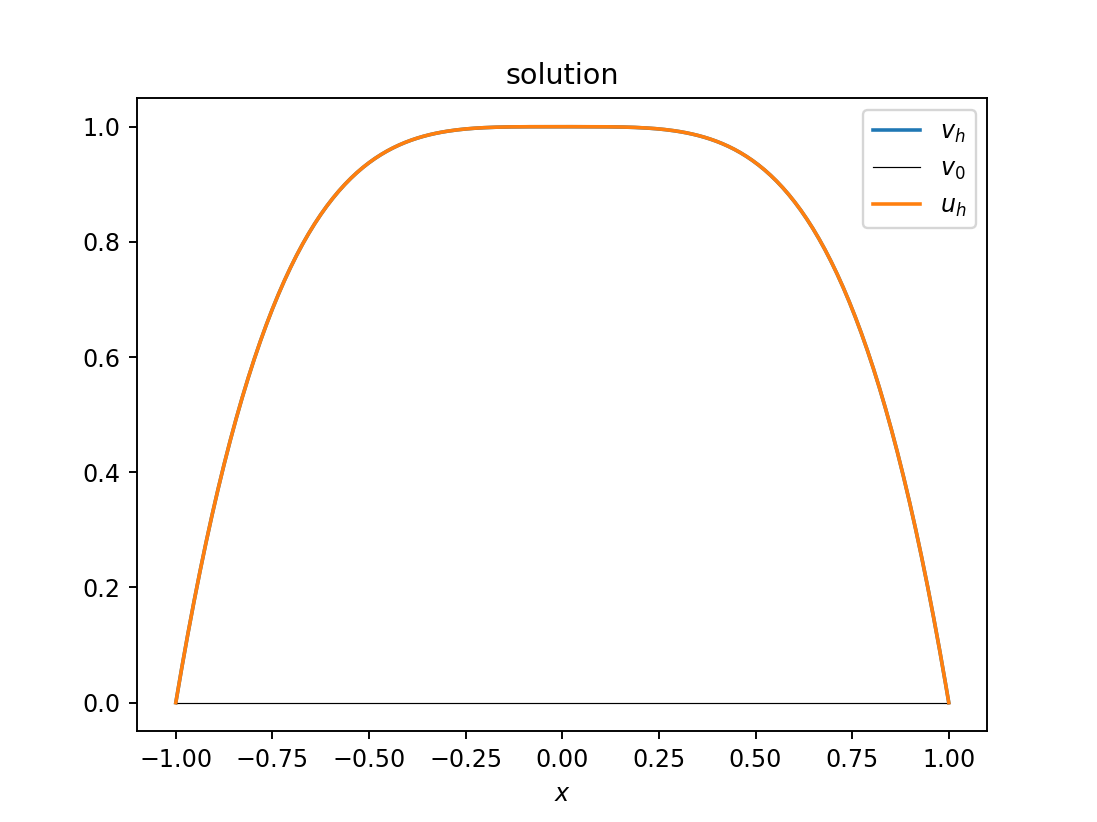

<IPython.core.display.Javascript object>


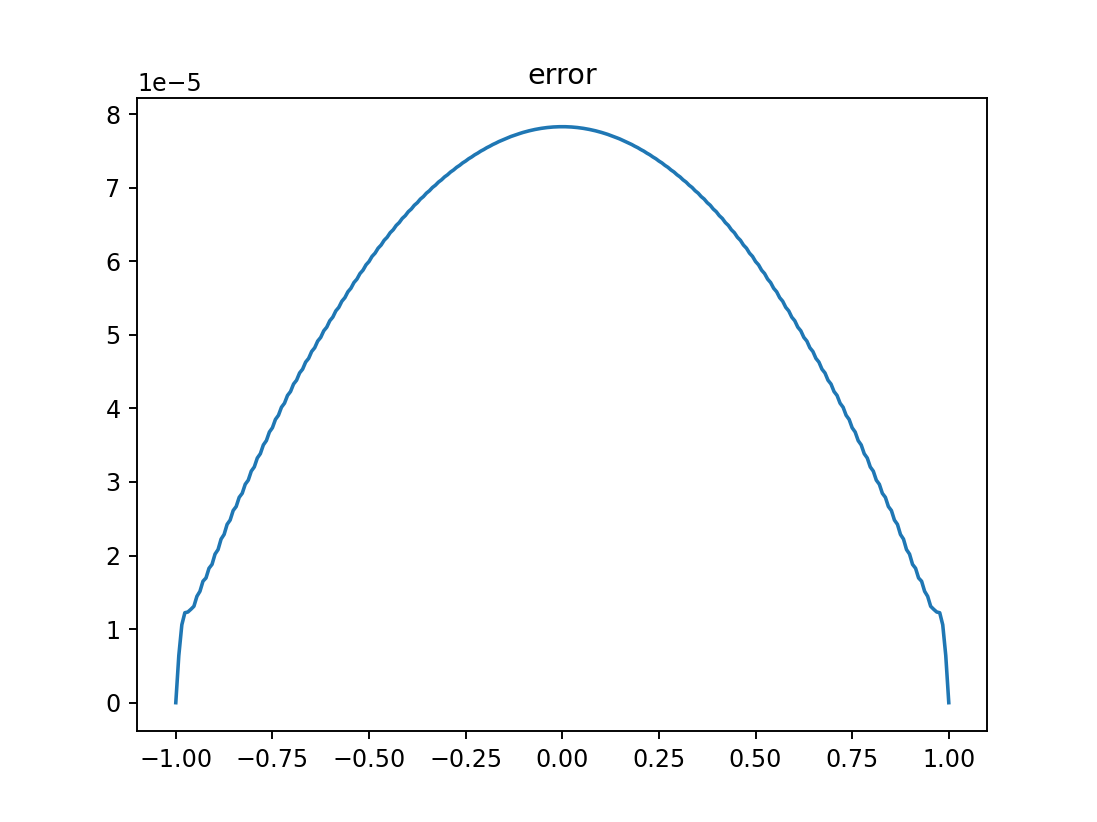

In [165]:
plt.close(1)
plt.figure(1)
plt.plot(x[0],u[0])
plt.plot(x[0],u0,lw=0.5,color='k')
plt.plot(x[0],g(x[0]))
plt.legend(('$v_h$','$v_0$','$u_h$'))
plt.xlabel('$x$')
plt.title('solution')

plt.close(2)
plt.figure(2)
plt.title('error')
plt.plot(x[0],np.fabs(u[0]-g(x[0])))

In [161]:
n


array([64, 32, 16,  8,  4,  2])